In [1]:
import datetime

In [2]:
now = datetime.datetime.now()

print(now)


2024-11-21 23:09:20.204088


### Importing libraries
---

In [5]:
import requests
from  geopy.geocoders import Nominatim
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import logging 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import seaborn as sns

import datetime
import math

import nltk
#from nerd import ner
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree 

from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

from IPython.display import HTML

import warnings
import csv

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(font_scale=1.4)

In [6]:
def load_data():
    df = pd.read_csv('data.csv')
    return df

In [7]:
data = load_data()

In [8]:
print("Data Shape ~ Rows = {} | Columns = {}".format(data.shape[0],data.shape[1])) #data.shape

Data Shape ~ Rows = 1025 | Columns = 17


In [9]:
data.columns

Index(['id', 'unique_id', 'government_id', 'diagnosed_date', 'age', 'gender',
       'detected_city', 'detected_city_pt', 'detected_district',
       'detected_state', 'nationality', 'current_status', 'status_change_date',
       'notes', 'current_location', 'current_location_pt', 'contacts'],
      dtype='object')

In [10]:
data.head()

,id,unique_id,government_id,diagnosed_date,age,gender,detected_city,detected_city_pt,detected_district,detected_state,nationality,current_status,status_change_date,notes,current_location,current_location_pt,contacts
0,1,1,KL-TS-P1,2020-01-30,20.0,Female,Thrissur,SRID=4326;POINT (76.21325419999999 10.5256264),Thrissur,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (76.21325419999999 10.5256264),[]
1,2,2,KL-AL-P1,2020-02-02,NaN,Unknown,Alappuzha,SRID=4326;POINT (76.333482 9.498000100000001),Alappuzha,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (76.333482 9.498000100000001),[]
2,3,3,KL-KS-P1,2020-02-03,NaN,Unknown,Kasaragod,SRID=4326;POINT (80 20),Kasaragod,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (80 20),[]
3,4,4,DL-P1,2020-03-02,45.0,Male,East Delhi (Mayur Vihar),SRID=4326;POINT (80 20),East Delhi,Delhi,India,Recovered,2020-03-15,"Travelled from Austria, Italy.\nTravel history...",NaN,SRID=4326;POINT (80 20),"[22,23,24,25,26,27,47]"
4,5,5,TS-P1,2020-03-02,24.0,Male,Hyderabad,SRID=4326;POINT (78.4349398685041 17.4263524),Hyderabad,Telangana,India,Recovered,2020-03-02,".\nTravel history to Dubai, Singapore contact",NaN,SRID=4326;POINT (78.4349398685041 17.4263524),[]


### COVID19 Confirmed cases current location
> Click on the map and counts to play with the graph.

In [11]:
def get_lat_long(string):       
    return string.replace('SRID=4326;POINT ','').strip(')(').split()

data["current_location_pt"]=data['current_location_pt'].fillna(data['current_location_pt'].mode().iloc[0])
data['current_loc_latlong'] = data['current_location_pt'].apply(get_lat_long)

data['current_lat'] = data['current_loc_latlong'].apply(lambda x:x[0])
data['current_long'] = data['current_loc_latlong'].apply(lambda x:x[1])

data.current_lat = data.current_lat.astype('float64')
data.current_long = data.current_long.astype('float64')

m_3 = folium.Map(location=[12.4996, 74.9869], tiles='cartodbpositron', zoom_start=4)

# Add points to the map
mc = MarkerCluster()
for idx, row in data.iterrows():
    if not math.isnan(row['current_long']) and not math.isnan(row['current_lat']):
        mc.add_child(Marker([row['current_long'], row['current_lat']]))
m_3.add_child(mc)

# Display the map
m_3

> On first look we see that the attributes 'id' and 'unique_id' are same. So we check if they have any values that are different.

#### Checking dtypes

In [12]:
data.dtypes

id                       int64
unique_id                int64
government_id           object
diagnosed_date          object
age                    float64
gender                  object
detected_city           object
detected_city_pt        object
detected_district       object
detected_state          object
nationality             object
current_status          object
status_change_date      object
notes                   object
current_location        object
current_location_pt     object
contacts                object
current_loc_latlong     object
current_lat            float64
current_long           float64
dtype: object

In [13]:
data[data['id'] == data['unique_id']].shape

(1023, 20)

> Since we have same values in both columns. We can drop one of them and make another as the index

In [14]:
data.drop('unique_id',axis=1,inplace=True)

In [15]:
data.set_index('id',inplace=True)

In [16]:
print("Data Shape ~ Rows = {} | Columns = {}".format(data.shape[0],data.shape[1]))

Data Shape ~ Rows = 1025 | Columns = 18


In [17]:
data.head()

,government_id,diagnosed_date,age,gender,detected_city,detected_city_pt,detected_district,detected_state,nationality,current_status,status_change_date,notes,current_location,current_location_pt,contacts,current_loc_latlong,current_lat,current_long
id,,,,,,,,,,,,,,,,,,
1,KL-TS-P1,2020-01-30,20.0,Female,Thrissur,SRID=4326;POINT (76.21325419999999 10.5256264),Thrissur,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (76.21325419999999 10.5256264),[],"[76.21325419999999, 10.5256264]",76.213254,10.525626
2,KL-AL-P1,2020-02-02,NaN,Unknown,Alappuzha,SRID=4326;POINT (76.333482 9.498000100000001),Alappuzha,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (76.333482 9.498000100000001),[],"[76.333482, 9.498000100000001]",76.333482,9.498000
3,KL-KS-P1,2020-02-03,NaN,Unknown,Kasaragod,SRID=4326;POINT (80 20),Kasaragod,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (80 20),[],"[80, 20]",80.000000,20.000000
4,DL-P1,2020-03-02,45.0,Male,East Delhi (Mayur Vihar),SRID=4326;POINT (80 20),East Delhi,Delhi,India,Recovered,2020-03-15,"Travelled from Austria, Italy.\nTravel history...",NaN,SRID=4326;POINT (80 20),"[22,23,24,25,26,27,47]","[80, 20]",80.000000,20.000000
5,TS-P1,2020-03-02,24.0,Male,Hyderabad,SRID=4326;POINT (78.4349398685041 17.4263524),Hyderabad,Telangana,India,Recovered,2020-03-02,".\nTravel history to Dubai, Singapore contact",NaN,SRID=4326;POINT (78.4349398685041 17.4263524),[],"[78.4349398685041, 17.4263524]",78.434940,17.426352


> Since government_id is of no use. We can drop it.

In [18]:
data['government_id'].isna().sum()

780

In [19]:
data.drop('government_id',axis=1,inplace=True)

#### Now we convert date columns to datetime objects since they are in string.

In [20]:
data.dtypes

diagnosed_date          object
age                    float64
gender                  object
detected_city           object
detected_city_pt        object
detected_district       object
detected_state          object
nationality             object
current_status          object
status_change_date      object
notes                   object
current_location        object
current_location_pt     object
contacts                object
current_loc_latlong     object
current_lat            float64
current_long           float64
dtype: object

In [21]:
date_columns = ['diagnosed_date','status_change_date']

In [22]:
for column in date_columns:
    data[column] = pd.to_datetime(data[column])

In [23]:
data.head()

,diagnosed_date,age,gender,detected_city,detected_city_pt,detected_district,detected_state,nationality,current_status,status_change_date,notes,current_location,current_location_pt,contacts,current_loc_latlong,current_lat,current_long
id,,,,,,,,,,,,,,,,,
1,2020-01-30,20.0,Female,Thrissur,SRID=4326;POINT (76.21325419999999 10.5256264),Thrissur,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (76.21325419999999 10.5256264),[],"[76.21325419999999, 10.5256264]",76.213254,10.525626
2,2020-02-02,NaN,Unknown,Alappuzha,SRID=4326;POINT (76.333482 9.498000100000001),Alappuzha,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (76.333482 9.498000100000001),[],"[76.333482, 9.498000100000001]",76.333482,9.498000
3,2020-02-03,NaN,Unknown,Kasaragod,SRID=4326;POINT (80 20),Kasaragod,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,NaN,SRID=4326;POINT (80 20),[],"[80, 20]",80.000000,20.000000
4,2020-03-02,45.0,Male,East Delhi (Mayur Vihar),SRID=4326;POINT (80 20),East Delhi,Delhi,India,Recovered,2020-03-15,"Travelled from Austria, Italy.\nTravel history...",NaN,SRID=4326;POINT (80 20),"[22,23,24,25,26,27,47]","[80, 20]",80.000000,20.000000
5,2020-03-02,24.0,Male,Hyderabad,SRID=4326;POINT (78.4349398685041 17.4263524),Hyderabad,Telangana,India,Recovered,2020-03-02,".\nTravel history to Dubai, Singapore contact",NaN,SRID=4326;POINT (78.4349398685041 17.4263524),[],"[78.4349398685041, 17.4263524]",78.434940,17.426352


#### Now the data is ready for analysis and preprocessing

In [24]:
#Checking null values
data.isna().sum()

diagnosed_date            0
age                     552
gender                    0
detected_city           388
detected_city_pt          0
detected_district       123
detected_state            0
nationality             619
current_status            1
status_change_date        3
notes                     4
current_location       1010
current_location_pt       0
contacts                  1
current_loc_latlong       0
current_lat               0
current_long              0
dtype: int64

> Imputing missing values with 'Unknown'

In [25]:
for i in data.columns:
    if data[i].dtype == 'object':
        data[i] = data[i].fillna('Unknown')

In [26]:
data.dtypes

diagnosed_date         datetime64[ns]
age                           float64
gender                         object
detected_city                  object
detected_city_pt               object
detected_district              object
detected_state                 object
nationality                    object
current_status                 object
status_change_date     datetime64[ns]
notes                          object
current_location               object
current_location_pt            object
contacts                       object
current_loc_latlong            object
current_lat                   float64
current_long                  float64
dtype: object

In [27]:
data.isna().sum()

diagnosed_date           0
age                    552
gender                   0
detected_city            0
detected_city_pt         0
detected_district        0
detected_state           0
nationality              0
current_status           0
status_change_date       3
notes                    0
current_location         0
current_location_pt      0
contacts                 0
current_loc_latlong      0
current_lat              0
current_long             0
dtype: int64

---
### Now the data is ready for EDA
> Understanding the involved factors in the growth of the Corona Virus via visualization
---

In [28]:
print("Number of Cities Affected from COVID19: ", data['detected_city'].nunique())
print("#----------------------------------------------------------------------------------------#")
print("Cities Affected: ", data[data['detected_city'].isna()==False]['detected_city'].unique())

Number of Cities Affected from COVID19:  182
#----------------------------------------------------------------------------------------#
Cities Affected:  ['Thrissur' 'Alappuzha' 'Kasaragod' 'East Delhi (Mayur Vihar)' 'Hyderabad'
 'Jaipur' 'Gurugram' 'Agra' 'Unknown' 'Janakpuri' 'Ghaziabad'
 'Uttam Nagar' 'Ladakh' 'Kancheepuram' 'Ranni' 'Tri Nagar' 'Jammu'
 'Bengaluru' 'Kannur' 'Pune' 'Amritsar' 'Kozhencherry' 'Kochi' 'Chengalam'
 'Chuchot' 'Mumbai' 'Nellore' 'Kalaburagi' 'Nagpur' 'Thane' 'Lucknow'
 'Delhi' 'Varkala' 'Nedumangad' 'Thiruvananthapuram' 'Ahmednagar'
 'Yavatmal' 'Munnar' 'Aurangabad' 'Pimpri-Chinchwad' 'Dehradun' 'Rajouri'
 'Kalanadu' 'Malappuram' 'Bhubaneswar' 'Saket' 'Kargil' 'Leh' 'Mahe'
 'Noida' 'Kolkata' 'Gautam Buddh Nagar' 'Chennai' 'Shrungartali' 'Khanyar'
 'Jhunjhunu' 'Dilshad Garden' 'Chandigarh' 'Kodagu' 'Ongole' 'Raipur'
 'Lakhimpur kheri' 'Banga' 'Eriyal' 'Rajkot' 'Surat' 'Visakapatnam'
 'Rana Pratap Bagh' 'Ashok Vihar' 'Gautam Puri' 'Beleghata' 'Mohali'
 'Chus

---
#### Analysis: 
#### There are total in total 4000 cities in India. Number of cities affected currently are "182".
---

In [29]:
print("Number of States Affected from COVID19: ", data['detected_state'].nunique())
print("#----------------------------------------------------------------------------------------#")
print("States Affected: ", data[data['detected_state'].isna()==False]['detected_state'].unique())

Number of States Affected from COVID19:  27
#----------------------------------------------------------------------------------------#
States Affected:  ['Kerala' 'Delhi' 'Telangana' 'Rajasthan' 'Haryana' 'Uttar Pradesh'
 'Ladakh' 'Tamil Nadu' 'Jammu and Kashmir' 'Karnataka' 'Maharashtra'
 'Punjab' 'Andhra Pradesh' 'Uttarakhand' 'Odisha' 'Puducherry'
 'West Bengal' 'Chandigarh' 'Chhattisgarh' 'Gujarat' 'Himachal Pradesh'
 'Madhya Pradesh' 'Bihar' 'Manipur' 'Mizoram' 'Goa'
 'Andaman and Nicobar Islands']


---
#### Analysis:
#### India is a federal union comprising 28 states and 8 union territories, for a total of 36 entities. The current affected entities are "27".
---

#### Let's observe the age factor for coronavirus spread
---

<Figure size 2000x1500 with 0 Axes>

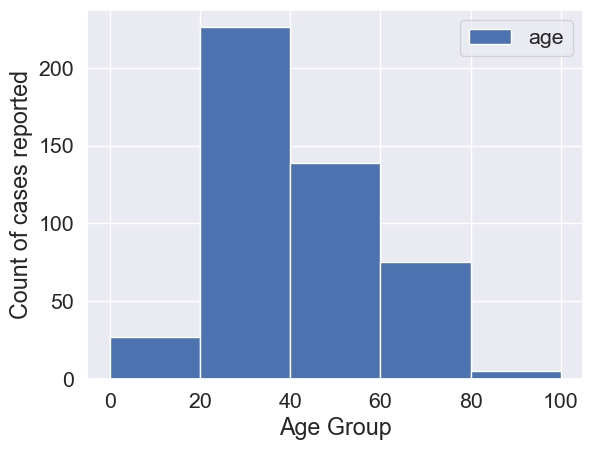

In [30]:
plt.figure(figsize=(20,15))
data[['age']].plot(kind='hist',bins=[0,20,40,60,80,100],rwidth=1.8)
plt.ylabel('Count of cases reported')
plt.xlabel('Age Group')
plt.show()

---
#### Analysis:
#### The most common affected people belongs to age group of 20-60.
---

> Graph between the count of affected people and Nationality.

In [31]:
data['nationality'].value_counts()

nationality
Unknown                     619
India                       360
Italy                        18
Indonesia                    14
United Kingdom                7
Phillipines                   2
Thailand                      2
Canada                        1
United States of America      1
France                        1
Name: count, dtype: int64

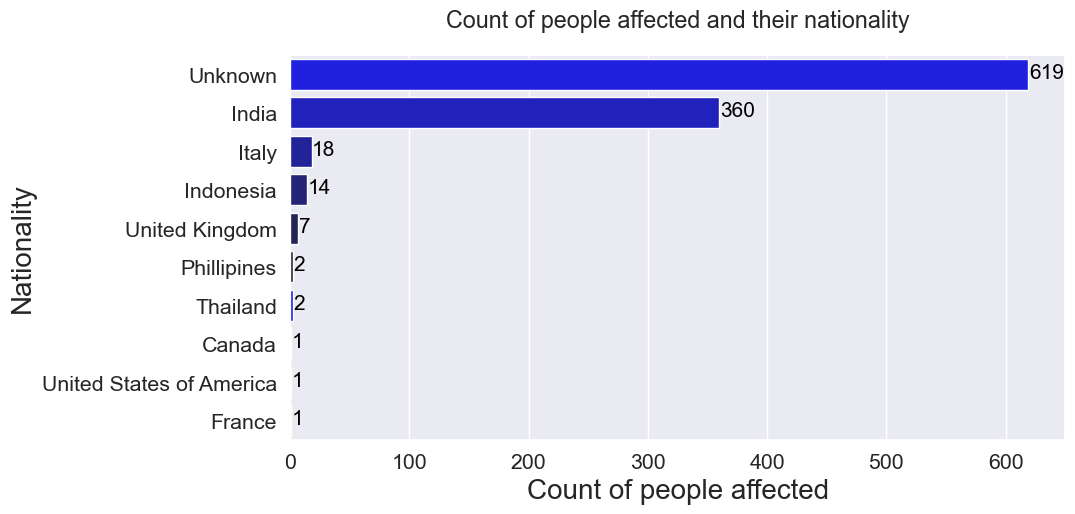

In [32]:
plt.figure(figsize=(10,5))
df=pd.DataFrame({'nationality':data['nationality'].value_counts().index,'Count':data['nationality'].value_counts().values})
ax=sns.barplot(x="Count",y="nationality",data=df, palette=sns.dark_palette("blue", reverse=True))
for i in ax.patches:
    ax.text(i.get_width()+0.50, i.get_y()+0.50, \
            str(int(i.get_width())), fontsize=15,color='black')
ax.set_title('Count of people affected and their nationality', pad=20)
plt.xlabel('Count of people affected', fontsize=20)
plt.ylabel('Nationality', fontsize=20)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=8)
plt.show()

> Graph between gender and count of affected people.

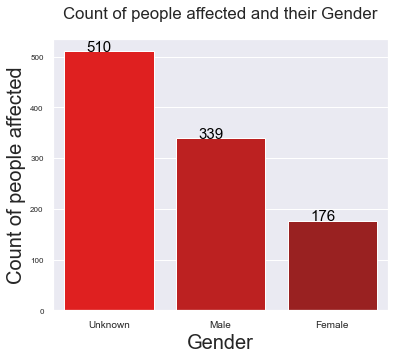

In [32]:
plt.figure(figsize=(6,5))
ax=sns.barplot(data['gender'].value_counts().index,data['gender'].value_counts().values, palette=sns.dark_palette("red", reverse=True))
for i in ax.patches:
    ax.text(i.get_x()+.20, i.get_height()+.9, \
            str(int(i.get_height())), fontsize=15,
                color='black')
ax.set_title('Count of people affected and their Gender', pad=20)
plt.ylabel('Count of people affected', fontsize=20)
plt.xlabel('Gender', fontsize=20)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.show()

> Graph between different states and number of detected cases.

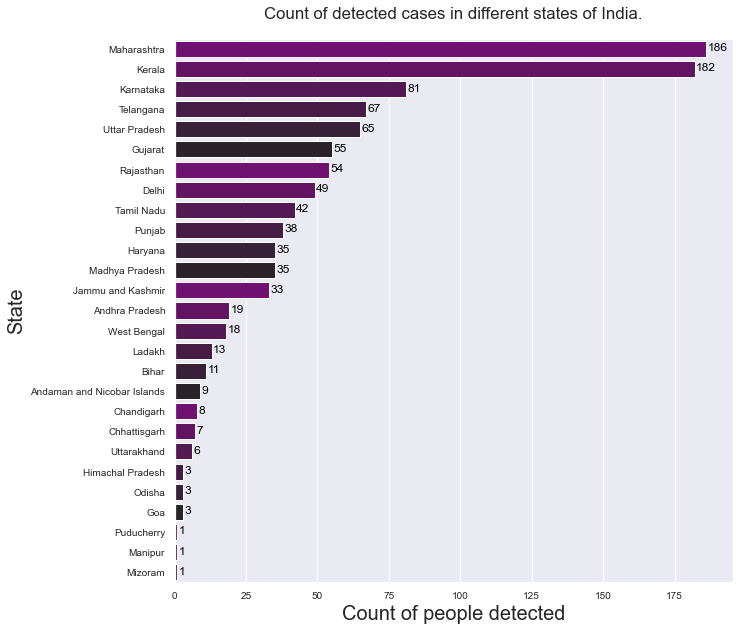

In [33]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data['detected_state'].value_counts().values,data['detected_state'].value_counts().index, palette=sns.dark_palette("purple", reverse=True))
for i in ax.patches:
    ax.text(i.get_width()+0.5, i.get_y()+0.5, \
            str(int(i.get_width())), fontsize=12,color='black')
ax.set_title('Count of detected cases in different states of India.', pad=20)
plt.xlabel('Count of people detected', fontsize=20)
plt.ylabel('State', fontsize=20)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=15)
plt.show()

#### The graph clearly shows that Maharashtra is the most affected state followed by Kerala 

> Graph displaying status and count of affected people.

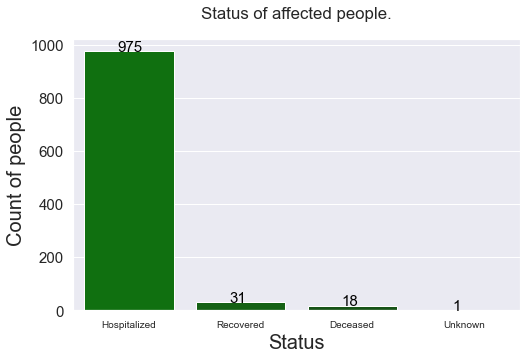

In [34]:
plt.figure(figsize=(8,5))
ax=sns.barplot(data['current_status'].value_counts().index,data['current_status'].value_counts().values, palette=sns.dark_palette("green", reverse=True))
for i in ax.patches:
    ax.text(i.get_x()+.30, i.get_height()+.10, \
            str(int(i.get_height())), fontsize=15,
                color='black')
ax.set_title('Status of affected people.', pad=20)
plt.ylabel('Count of people', fontsize=20)
plt.xlabel('Status', fontsize=20)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=8)
plt.show()

> No. of people affected district wise

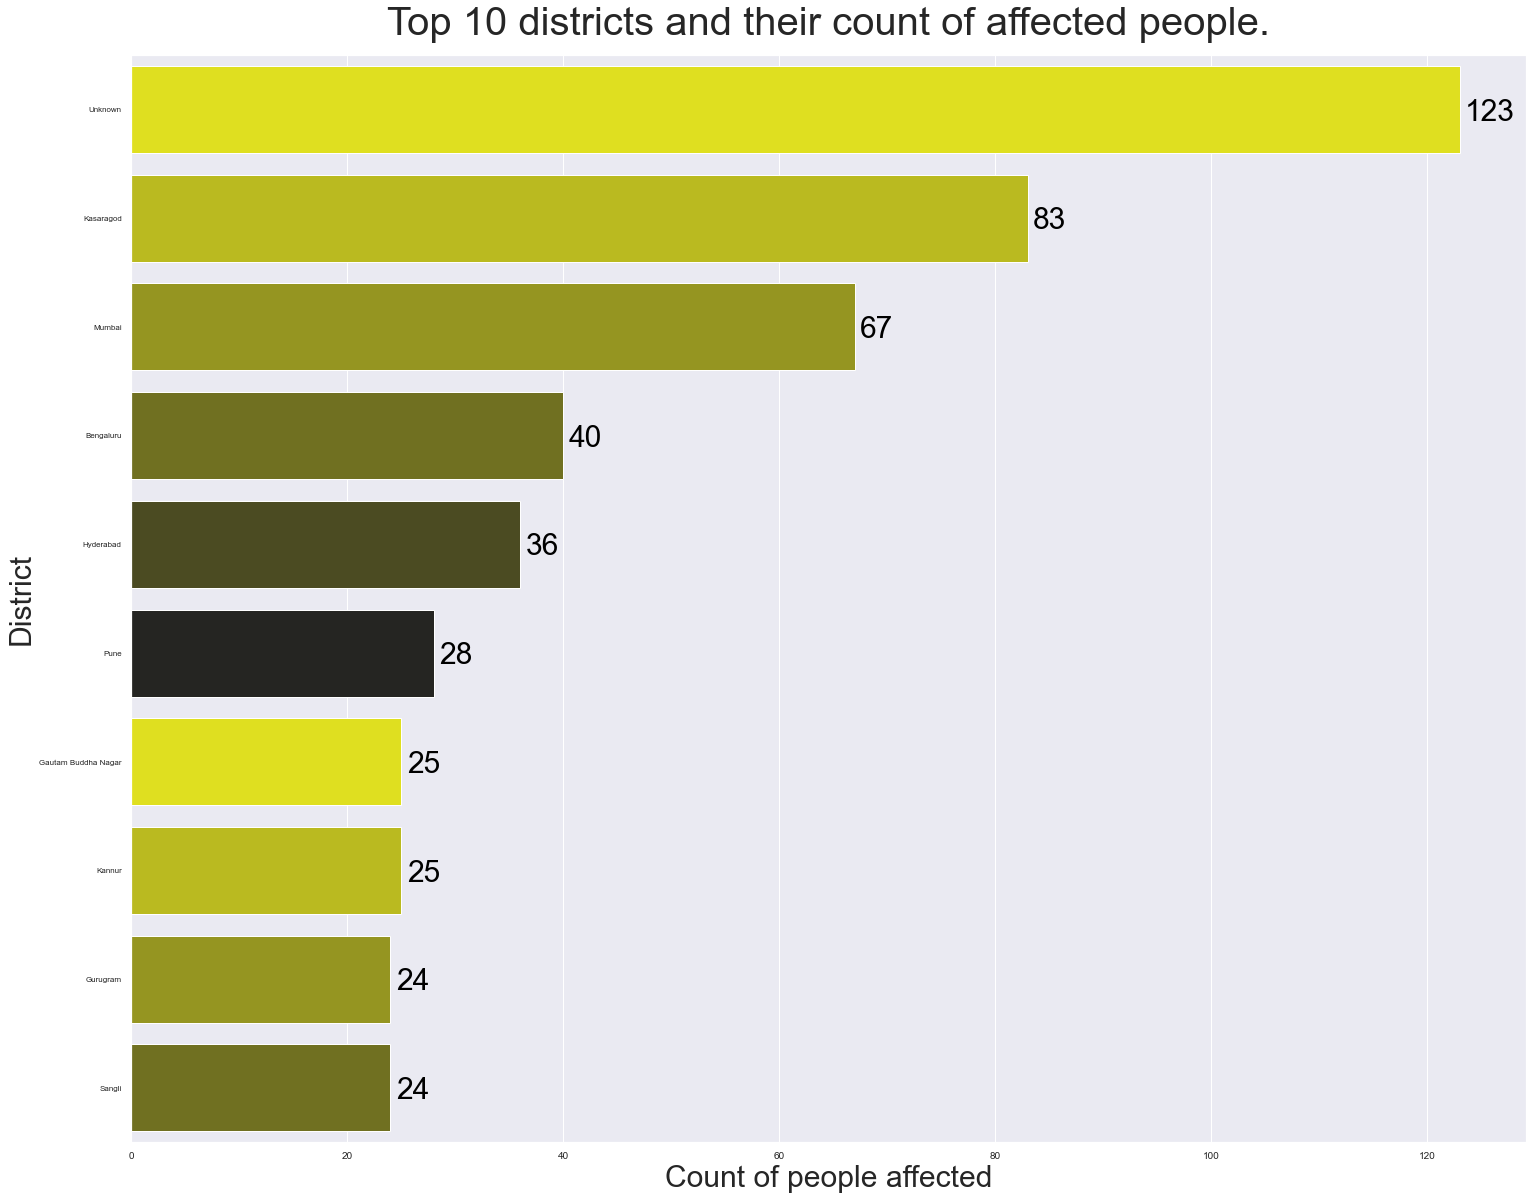

In [35]:
plt.figure(figsize=(25,20))
ax=sns.barplot(data['detected_district'].value_counts()[:10].values,data['detected_district'].value_counts()[:10].index, palette=sns.dark_palette("yellow", reverse=True))
for i in ax.patches:
    ax.text(i.get_width()+0.50, i.get_y()+0.50, \
            str(int(i.get_width())), fontsize=30,color='black')
ax.set_title('Top 10 districts and their count of affected people.', pad=20,fontsize=40)
plt.xlabel('Count of people affected', fontsize=30)
plt.ylabel('District', fontsize=30)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.show()

> Graph showing relationship between current status and age of people

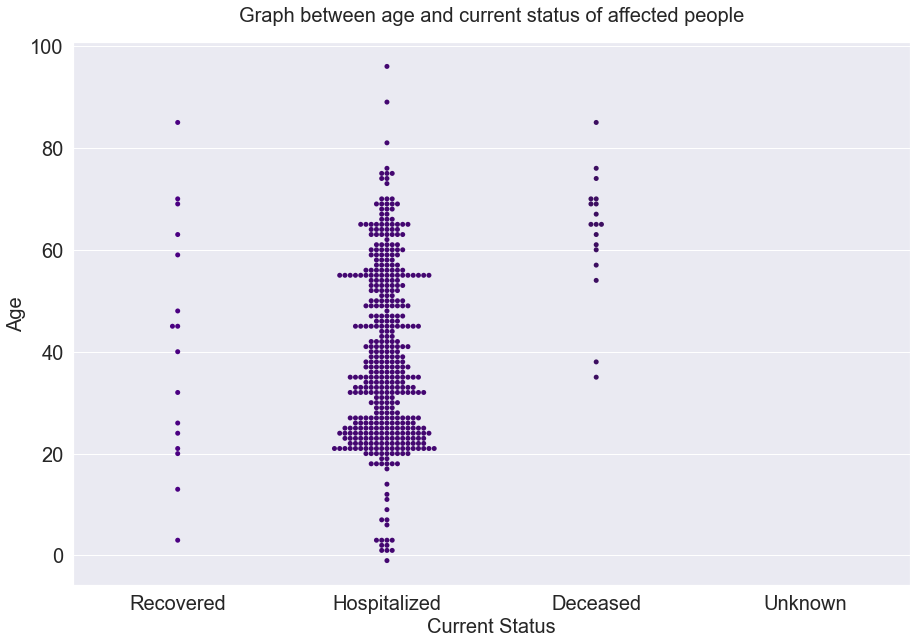

In [36]:
plt.figure(figsize=(15,10))
ax=sns.swarmplot(data['current_status'],data['age'],palette=sns.dark_palette("indigo", reverse=True))
ax.set_title('Graph between age and current status of affected people', pad=20,fontsize=20)
plt.xlabel('Current Status', fontsize=20)
plt.ylabel('Age', fontsize=20)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

#### This swarmplot shows that majority of the people hospitalized are in the age group of ~18 to 88

#### No. of days between change in status

In [37]:
data.head()

,diagnosed_date,age,gender,detected_city,detected_city_pt,detected_district,detected_state,nationality,current_status,status_change_date,notes,current_location,current_location_pt,contacts,current_loc_latlong,current_lat,current_long
id,,,,,,,,,,,,,,,,,
1,2020-01-30,20.0,Female,Thrissur,SRID=4326;POINT (76.21325419999999 10.5256264),Thrissur,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,Unknown,SRID=4326;POINT (76.21325419999999 10.5256264),[],"[76.21325419999999, 10.5256264]",76.213254,10.525626
2,2020-02-02,NaN,Unknown,Alappuzha,SRID=4326;POINT (76.333482 9.498000100000001),Alappuzha,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,Unknown,SRID=4326;POINT (76.333482 9.498000100000001),[],"[76.333482, 9.498000100000001]",76.333482,9.498000
3,2020-02-03,NaN,Unknown,Kasaragod,SRID=4326;POINT (80 20),Kasaragod,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,Unknown,SRID=4326;POINT (80 20),[],"[80, 20]",80.000000,20.000000
4,2020-03-02,45.0,Male,East Delhi (Mayur Vihar),SRID=4326;POINT (80 20),East Delhi,Delhi,India,Recovered,2020-03-15,"Travelled from Austria, Italy.\nTravel history...",Unknown,SRID=4326;POINT (80 20),"[22,23,24,25,26,27,47]","[80, 20]",80.000000,20.000000
5,2020-03-02,24.0,Male,Hyderabad,SRID=4326;POINT (78.4349398685041 17.4263524),Hyderabad,Telangana,India,Recovered,2020-03-02,".\nTravel history to Dubai, Singapore contact",Unknown,SRID=4326;POINT (78.4349398685041 17.4263524),[],"[78.4349398685041, 17.4263524]",78.434940,17.426352


#### Days taken to change status(Hospitalized/Death/Recover)

In [38]:
data['status change difference'] = pd.to_datetime(data['status_change_date'])-pd.to_datetime(data['diagnosed_date'])

In [39]:
data['status change difference'].value_counts()

0 days     978
1 days      17
11 days      4
2 days       4
-1 days      3
16 days      2
12 days      2
14 days      2
9 days       2
18 days      1
17 days      1
8 days       1
3 days       1
7 days       1
13 days      1
6 days       1
15 days      1
Name: status change difference, dtype: int64

### Graph to show relationship between status change

---

In [40]:
data.head()

,diagnosed_date,age,gender,detected_city,detected_city_pt,detected_district,detected_state,nationality,current_status,status_change_date,notes,current_location,current_location_pt,contacts,current_loc_latlong,current_lat,current_long,status change difference
id,,,,,,,,,,,,,,,,,,
1,2020-01-30,20.0,Female,Thrissur,SRID=4326;POINT (76.21325419999999 10.5256264),Thrissur,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,Unknown,SRID=4326;POINT (76.21325419999999 10.5256264),[],"[76.21325419999999, 10.5256264]",76.213254,10.525626,15 days
2,2020-02-02,NaN,Unknown,Alappuzha,SRID=4326;POINT (76.333482 9.498000100000001),Alappuzha,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,Unknown,SRID=4326;POINT (76.333482 9.498000100000001),[],"[76.333482, 9.498000100000001]",76.333482,9.498000,12 days
3,2020-02-03,NaN,Unknown,Kasaragod,SRID=4326;POINT (80 20),Kasaragod,Kerala,India,Recovered,2020-02-14,Travelled from Wuhan.\nStudent from Wuhan,Unknown,SRID=4326;POINT (80 20),[],"[80, 20]",80.000000,20.000000,11 days
4,2020-03-02,45.0,Male,East Delhi (Mayur Vihar),SRID=4326;POINT (80 20),East Delhi,Delhi,India,Recovered,2020-03-15,"Travelled from Austria, Italy.\nTravel history...",Unknown,SRID=4326;POINT (80 20),"[22,23,24,25,26,27,47]","[80, 20]",80.000000,20.000000,13 days
5,2020-03-02,24.0,Male,Hyderabad,SRID=4326;POINT (78.4349398685041 17.4263524),Hyderabad,Telangana,India,Recovered,2020-03-02,".\nTravel history to Dubai, Singapore contact",Unknown,SRID=4326;POINT (78.4349398685041 17.4263524),[],"[78.4349398685041, 17.4263524]",78.434940,17.426352,0 days


In [41]:
diagnose_data=pd.DataFrame({'Dates':pd.to_datetime(data['diagnosed_date']).value_counts().index,
                           'Count':pd.to_datetime(data['diagnosed_date']).value_counts().values})
diagnose_data=diagnose_data.sort_values('Dates')
diagnose_data=diagnose_data.reset_index(drop=True)
diagnose_data=diagnose_data.set_index('Dates')

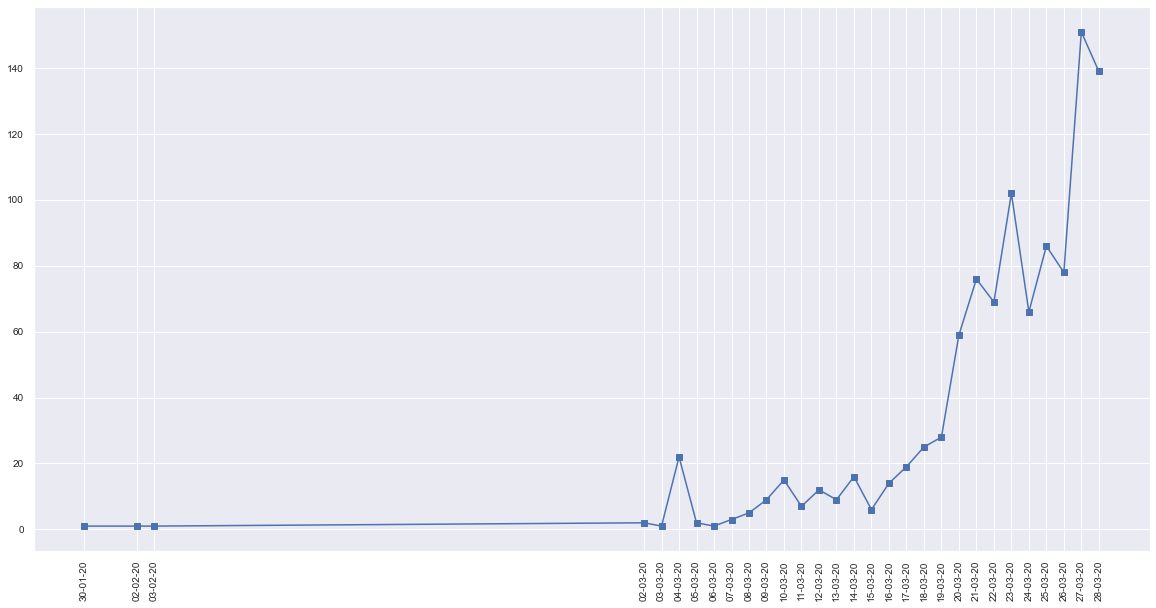

In [42]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20,10))
graph=ax.plot(diagnose_data.Count,marker='s')
myFmt = mdates.DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(myFmt)
plt.rc('xtick',labelsize=8)
plt.xticks(diagnose_data.index.values,rotation=90)
plt.show()

In [43]:
diagnose_data['cumsum']=diagnose_data['Count'].cumsum()

In [44]:
diagnose_data['cumsum']

Dates
2020-01-30       1
2020-02-02       2
2020-02-03       3
2020-03-02       5
2020-03-03       6
2020-03-04      28
2020-03-05      30
2020-03-06      31
2020-03-07      34
2020-03-08      39
2020-03-09      48
2020-03-10      63
2020-03-11      70
2020-03-12      82
2020-03-13      91
2020-03-14     107
2020-03-15     113
2020-03-16     127
2020-03-17     146
2020-03-18     171
2020-03-19     199
2020-03-20     258
2020-03-21     334
2020-03-22     403
2020-03-23     505
2020-03-24     571
2020-03-25     657
2020-03-26     735
2020-03-27     886
2020-03-28    1025
Name: cumsum, dtype: int64

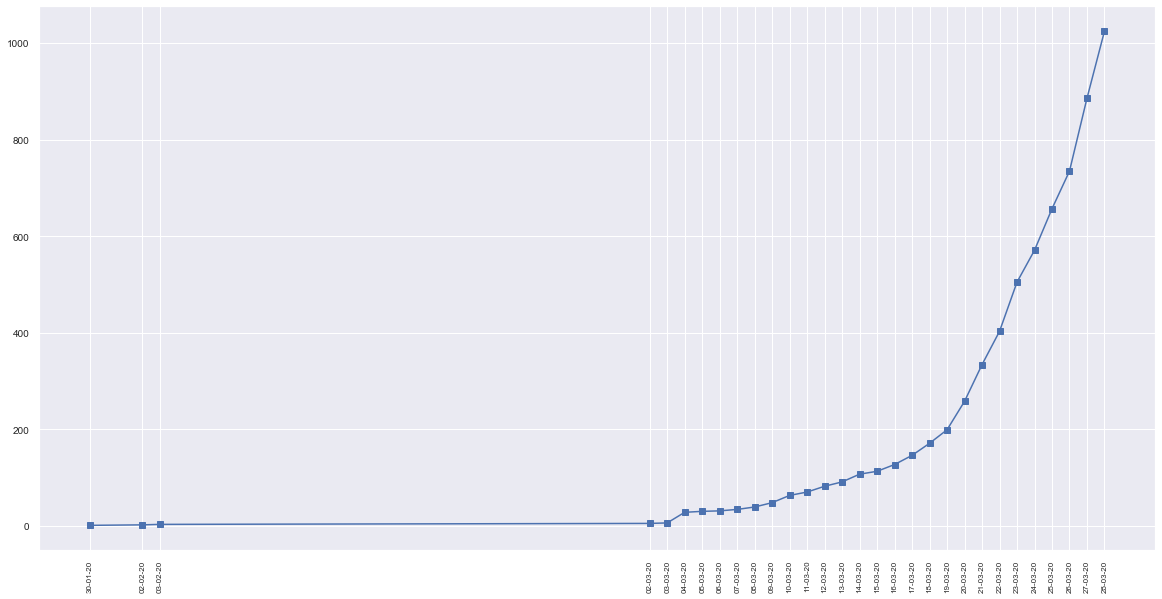

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
graph=ax.plot(diagnose_data['cumsum'],marker='s')
myFmt = mdates.DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(myFmt)
plt.rc('xtick',labelsize=10)
plt.xticks(diagnose_data.index.values,rotation=90)
plt.show()

### Data fetched from local news about the shutdown process in India.

In [46]:
entities = ['schools & other educational organization shutdown','public places shutdown',
            'work from home started for employees','country under lockdown','after lockdown']
dates = ['2020-03-10','2020-03-13','2020-03-16','2020-03-21','2020-03-26']

Using  boolean mask to fetch case counts within dates

In [47]:
# Now getting the cases count before each entity shutdown.
data = data.sort_values(by="diagnosed_date")

In [48]:
mask1 = (data['diagnosed_date'] > '2020-01-30') & (data['diagnosed_date'] <= '2020-03-09') # before school lockdown
mask1 = len(data.loc[mask1])
mask2 = (data['diagnosed_date'] > '2020-03-10') & (data['diagnosed_date'] <= '2020-03-12') #before public place shutdown
mask2 = len(data.loc[mask2])
mask3 = (data['diagnosed_date'] > '2020-03-13') & (data['diagnosed_date'] <= '2020-03-15') # beforw wfh
mask3 = len(data.loc[mask3])
mask4 = (data['diagnosed_date'] > '2020-03-16') & (data['diagnosed_date'] <= '2020-03-21') # beforw lookdown
mask4 = len(data.loc[mask4])
mask5 = (data['diagnosed_date'] > '2020-03-22') & (data['diagnosed_date'] <= '2020-03-28') # after lookdown
mask5 = len(data.loc[mask5])

In [49]:
case_counts = [mask1, mask2, mask3, mask4, mask5]

In [50]:
plot_data = pd.DataFrame({'dates':dates,'counts':case_counts,'entities': entities})

In [51]:
plot_data['dates'] = pd.to_datetime(plot_data['dates'])

In [52]:
plot_data

,dates,counts,entities
0,2020-03-10,47,schools & other educational organization shutdown
1,2020-03-13,19,public places shutdown
2,2020-03-16,22,work from home started for employees
3,2020-03-21,207,country under lockdown
4,2020-03-26,622,after lockdown


Text(0.5, 0, 'Covid19 Case Count')

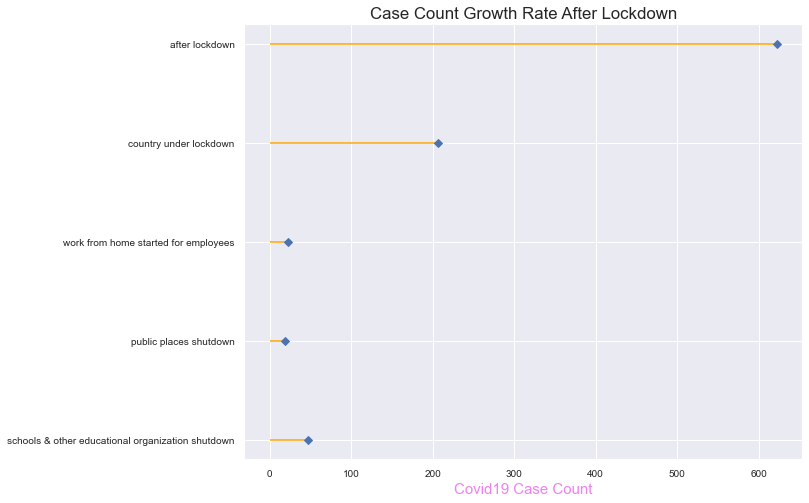

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
plt.hlines(y=plot_data.entities, xmin=0, xmax=plot_data.counts, color='orange')
plt.plot(plot_data.counts, plot_data.entities, "D")
# Add titles and axis names
ax.xaxis.label.set_color('violet')
plt.yticks(plot_data.entities)
plt.title("Case Count Growth Rate After Lockdown")
plt.xlabel('Covid19 Case Count', fontsize=15)

#### Analysis: Even after lockdown more cases are being reported everyday